## AstroQuery

**AstroQuery** is a Python library to query and analyze astronomical catalogues. Many astronomical catalogues are available online through a web service called [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR) operated by CDS (Strasbourg Astronomical Data Centre). VizieR catalogues can be loaded into Python using AstroQuery as will be demonstrated in this notebook.

This notebook is based on the corresponding [AstroPy tutorial](https://learn.astropy.org/rst-tutorials/4-Coordinates-Crossmatch.html?highlight=filtertutorials).

We will attempt to construct an optical / infrared colour-magnitude diagram for open cluster [NGC 188](https://en.wikipedia.org/wiki/NGC_188). Optical magnitudes will be taken from Gaia EDR3 catalogue ([I/350](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/350) on VizieR). Infrared magnitudes will be taken from the 2MASS catalogue ([II/246](https://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=II/246/out) on VizieR).

## Install AstroQuery

To install AstroQuery, run `pip install astroquery` in your terminal (use Conda Propmpt on Windows). On Google Colab, run the cell below:

In [1]:
!pip install astroquery

## Load the catalogues

Define a `SkyCoord` object with the average coordinates of the cluster which may be looked up on [Simbad](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=NGC+188). AstroQuery can query Simbad directly as demonstrated [here](https://astroquery.readthedocs.io/en/latest/simbad/simbad.html); however this feature will not be covered in this tutorial.

In [2]:
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import Angle, Distance

# Simbad provides parallax instead of distance. However, we can convert one into
# the other using AstroPy tools
ngc188_distance = Distance(parallax = Angle(0.5053 * u.mas))

ngc188_center_3d = SkyCoord(ra            = 12.11 * u.deg,
                            dec           = 85.26 * u.deg,
                            distance      = ngc188_distance,
                            pm_ra_cosdec  = -2.3087 * u.mas / u.yr,
                            pm_dec        = -0.9565 * u.mas / u.yr)

We now query the stars in the cluster from the Gaia EDR3 catalogue on VizieR and define a `SkyCoord` object for them as well:

In [3]:
from astroquery.vizier import Vizier
from astropy.time import Time
import numpy as np

v = Vizier(catalog = "I/350")         #   I/350 is Gaia eDR3 catalogue
v.ROW_LIMIT = -1                      #   Remove the default row limit to get
                                      #   all the stars

# Query all Gaia stars within 0.5 degrees of the cluster centre
result = v.query_region(ngc188_center_3d, radius = 0.5 * u.deg)
gaia_table = result[0]

# Remove stars that are too faint
gaia_table = gaia_table[gaia_table['Gmag'] < 19]
# Remove stars that are too far away
gaia_table = gaia_table[gaia_table['Plx'] > 0.25 * u.mas]

# Create a SkyCoord object containing the coordinates of all of the queried stars
ngc188_coords = SkyCoord(
    ra = gaia_table['RA_ICRS'],
    dec = gaia_table['DE_ICRS'],
    distance = Distance(parallax = Angle(gaia_table['Plx'])),
    pm_ra_cosdec = gaia_table['pmRA'],
    pm_dec = gaia_table['pmDE'],
    obstime = Time('J2016'))   #  Gaia EDR3 observations are all in J2016

# Calculate 3D separations
sep3d = ngc188_coords.separation_3d(ngc188_center_3d)
# Calculate velocity space separations (use Pythagoras)
pm_diff = np.sqrt(
    (ngc188_coords.pm_ra_cosdec - ngc188_center_3d.pm_ra_cosdec)**2 +
    (ngc188_coords.pm_dec - ngc188_center_3d.pm_dec)**2)

# Stars that are too far from each other in 3D space (say, further than
# 50 pc) or stars that have very different proper motions (say, more than
# 1.5 mas / yr) do not belong to the cluster
ngc188_members_mask = (sep3d < 50 * u.pc) & (pm_diff < 1.5 * u.mas/u.yr)
ngc188_coords = ngc188_coords[ngc188_members_mask]

# Print total number of identified members
len(ngc188_coords)

244

Now load cluster stars from the 2MASS catalogue. We are not going to verify membership here because we will eventually cross-match them onto Gaia stars and non-members will not find matches and disappear on their own

In [4]:
v = Vizier(catalog = "II/246", columns=['*', 'Date'])       # Include date of observation
v.ROW_LIMIT = -1

result = v.query_region(ngc188_center_3d, radius = 0.5 * u.deg)
tmass_table = result[0]
len(tmass_table)

5014

## Cross-match

Define a `Time` object for the date when 2MASS observations were taken:

In [5]:
tmass_epoch = Time(np.unique(tmass_table['Date']))

Define a `SkyCoord` object for 2MASS stars (we only need RA and DEC):

In [6]:
tmass_coords = SkyCoord(tmass_table['RAJ2000'], tmass_table['DEJ2000'])

Advance Gaia coordinates to the 2MASS observation date so that we could compare the two together:

In [7]:
ngc188_coords_1999 = ngc188_coords.apply_space_motion(tmass_epoch)

Run the cross-match:

In [8]:
idx_gaia, sep2d_gaia, sep3d = ngc188_coords_1999.match_to_catalog_sky(tmass_coords)

# idx_gaia stores indices of matches to each of the Gaia stars in the 2MASS catalogue
# sep2d_gaia stores 2D separations between the original star and its match
# sep3d stores 3D separations; however, they will be incorrect since we loaded 2MASS
# stars without 3D data

Plot a histogram of separations:

Text(0.5, 0, 'Separation [arcsec]')

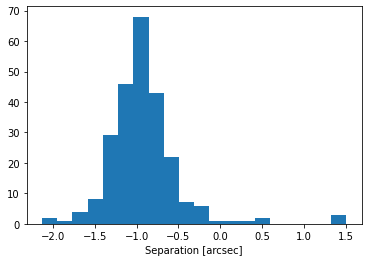

In [9]:
import matplotlib.pyplot as plt

plt.hist(np.log10(sep2d_gaia.arcsec), bins = 20);
plt.xlabel('Separation [arcsec]')

Get apparent J and G magnitudes

In [12]:
Jmag = tmass_table['Jmag'][idx_gaia]          # Use the cross-match indices
Gmag = gaia_table[ngc188_members_mask]['Gmag']

Plot the colour-magnitude diagram:

Text(0, 0.5, 'G')

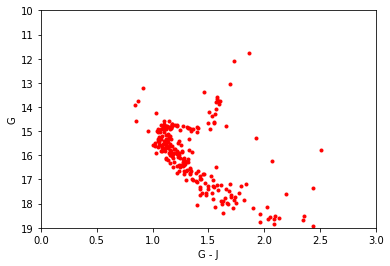

In [13]:
plt.plot(Gmag - Jmag, Gmag, 'r.')
plt.xlim(0, 3)
plt.ylim(19, 10)

plt.xlabel('G - J')
plt.ylabel('G')